# Image Histogram Equalization Analysis

This notebook explores the effects of iterative histogram equalization on images and analyzes how the cumulative probability distribution changes with each iteration.

## Objective
- Perform multiple iterations of histogram equalization on grayscale images
- Calculate and compare the distance between:
  - The cumulative probability distribution after each iteration
  - The ideal uniform cumulative probability distribution
- Visualize how the image and its histogram evolve through iterations

## Method
1. Load grayscale TIF images
2. Calculate initial histogram and cumulative probability distribution
3. Perform histogram equalization iteratively (n times)
4. For each iteration:
   - Calculate new histogram and cumulative probability
   - Compute distance from uniform distribution
   - Save transformed image
5. Plot and compare results

## Expected Outcomes
- Understanding how quickly histogram equalization converges
- Analyzing the relationship between visual image quality and statistical uniformity
- Determining optimal number of iterations for practical applications

## Implementation Details
- Using 8-bit grayscale images (256 intensity levels)
- PIL library for image processing
- NumPy for numerical computations and statistical analysis

##### By AARMN


In [30]:
#%% Load Images and Libs

from PIL import Image
from glob import glob
import numpy as np

image_paths = glob("images/*.tif")
image_names = [path.split('\\')[-1].split('.')[0] for path in image_paths]
image_list = [Image.open(path) for path in image_paths]


In [31]:
image_names

['bone-xray', 'fetus-us', 'map', 'peppers', 'tungsten-em']

In [32]:
#%% Histogram Calculator

def histogram_calculator(img, depth=8):
    """
    Calculate the histogram of an image
    """
    vals = np.arange(2**depth, dtype=np.uint64) 
    pixels = list(img.getdata())
    for pixel in pixels:
        vals[pixel] += 1
    return vals

In [33]:
#%% Calculate CumSum

def prob_calculator(hist):
    """
    Calculate probability of each value in a histogram
    """
    return hist / np.sum(hist)

def cumsum_calculator(prob):
    """
    Calculate the cumulative sum of a histogram probability
    """
    return np.cumsum(prob)


In [34]:
def uniform_prob_and_cumsum(depth=8):
    """
    Generate uniform probability distribution and its cumulative sum for given bit depth
    
    Parameters:
    depth: int - bit depth of the image (default 8)
    
    Returns:
    tuple (prob, cumsum) - uniform probability array and its cumulative sum as float64 arrays
    """
    # Create uniform probability distribution
    size = 2**depth
    prob = np.full(size, 1/size, dtype=np.float64)
    
    # Calculate cumulative sum
    cumsum = cumsum_calculator(prob)
    
    return prob, cumsum


In [35]:
uniform_prob, uniform_cdf = uniform_prob_and_cumsum()

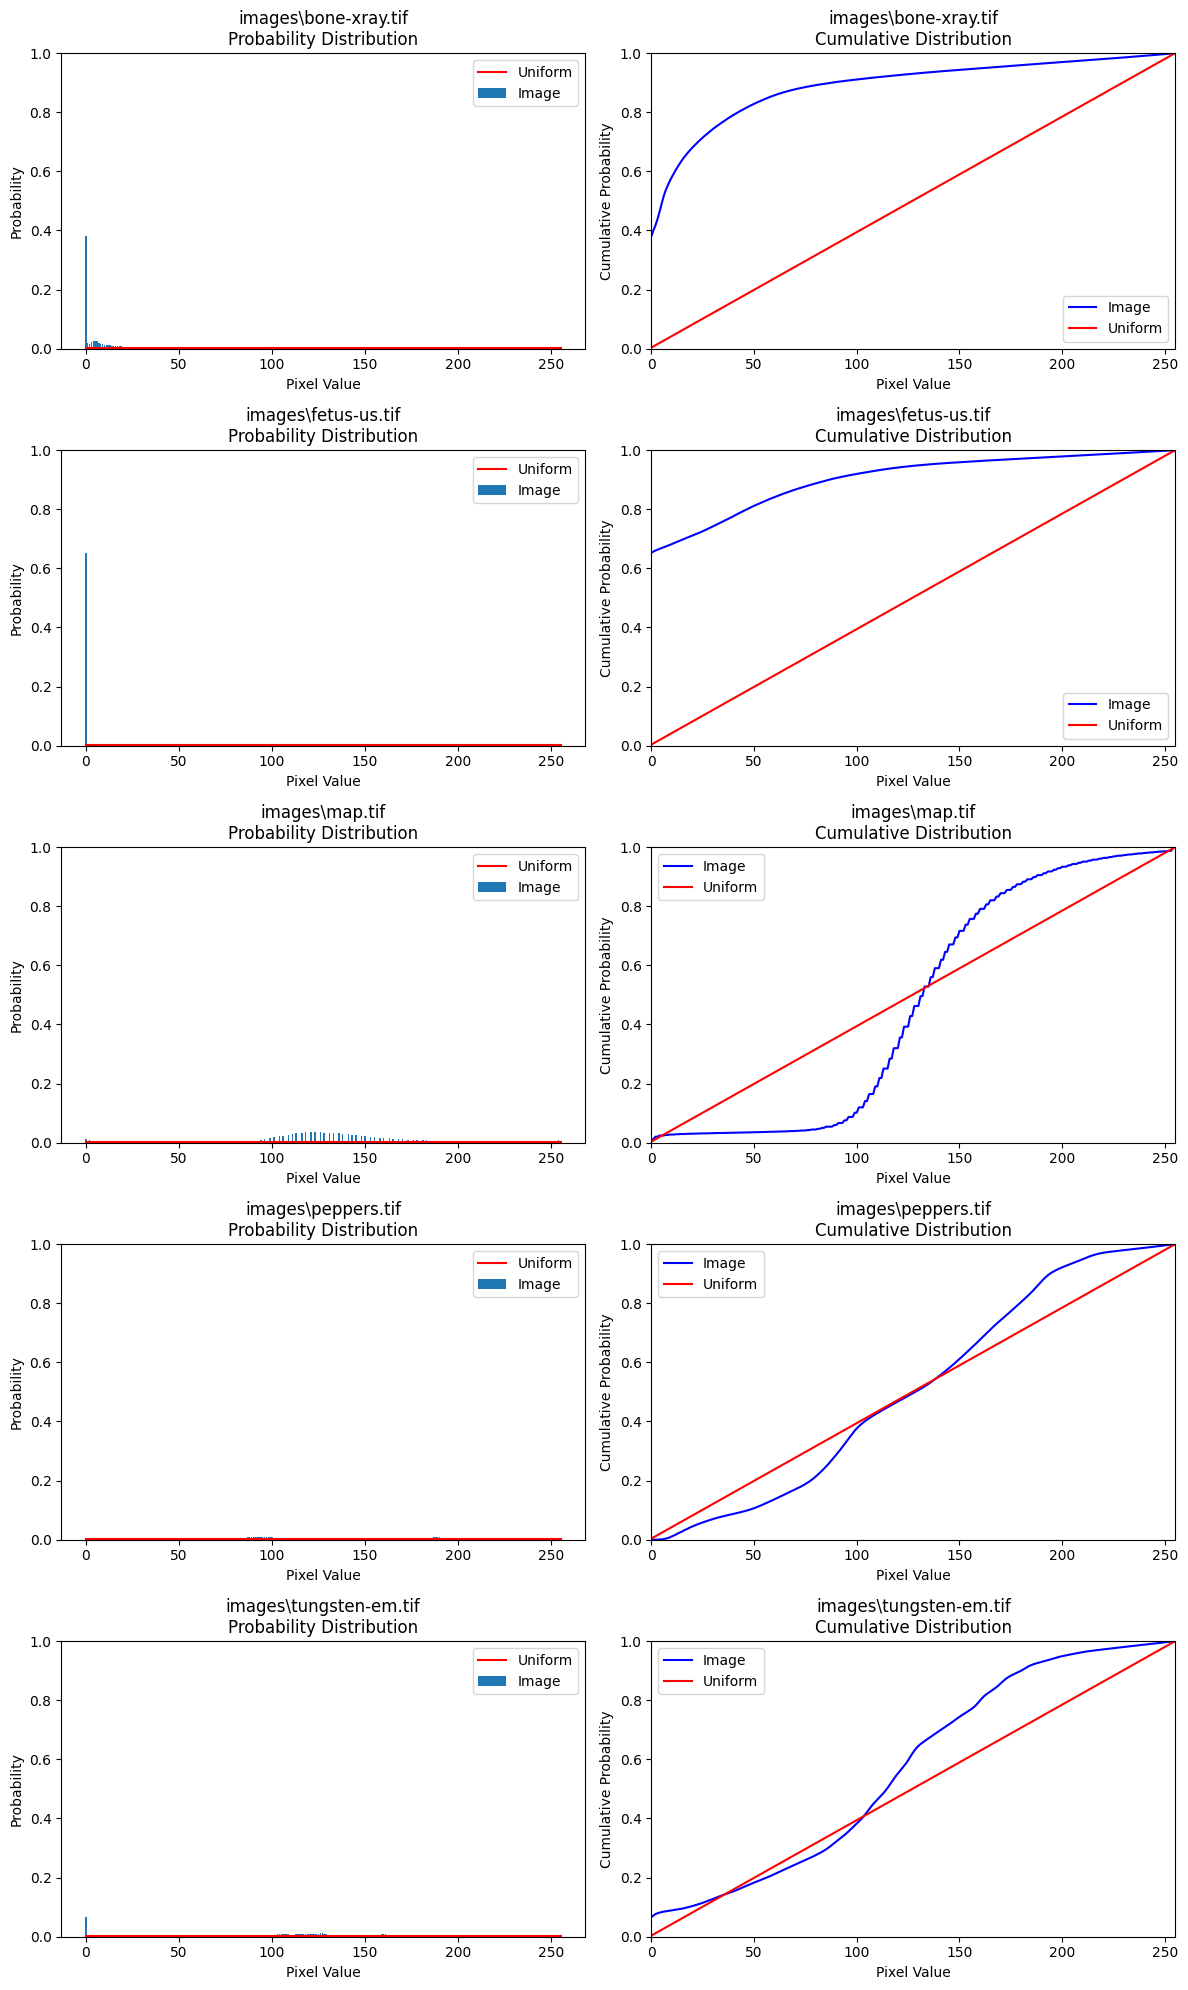

In [36]:
# draw histogram probability and cumsum curve of all images using matplotlib

import matplotlib.pyplot as plt

# Create a figure with multiple subplots based on number of images
n_images = len(image_list)
fig, axes = plt.subplots(n_images, 2, figsize=(12, 4*n_images))

# Handle case of single image
if n_images == 1:
    axes = axes.reshape(1, -1)

for idx, (img, filepath) in enumerate(zip(image_list, glob("images/*.tif"))):
    try:
        # Get image filename
        img_name = filepath.split('/')[-1]
        
        # Calculate histogram and probabilities
        hist = histogram_calculator(img)
        prob = prob_calculator(hist)
        cumsum = cumsum_calculator(prob)
        
        # Get uniform distributions
        uniform_prob, uniform_cumsum = uniform_prob_and_cumsum()
        
        # Plot histogram probabilities
        axes[idx, 0].bar(range(len(prob)), prob, label='Image')
        axes[idx, 0].plot(range(len(uniform_prob)), uniform_prob, 'r-', label='Uniform')
        axes[idx, 0].legend()
        axes[idx, 0].set_title(f'{img_name}\nProbability Distribution')
        axes[idx, 0].set_xlabel('Pixel Value')
        axes[idx, 0].set_ylabel('Probability')
        axes[idx, 0].set_ylim(0, 1)  # Set fixed y-axis range
        
        # Plot cumulative sum
        axes[idx, 1].plot(range(len(cumsum)), cumsum, 'b-', label='Image')
        axes[idx, 1].plot(range(len(uniform_cumsum)), uniform_cumsum, 'r-', label='Uniform')
        axes[idx, 1].legend()
        axes[idx, 1].set_title(f'{img_name}\nCumulative Distribution')
        axes[idx, 1].set_xlabel('Pixel Value')
        axes[idx, 1].set_ylabel('Cumulative Probability')
        axes[idx, 1].set_ylim(0, 1)  # Set fixed y-axis range
        axes[idx, 1].set_xlim(0, len(cumsum)-1)  # Set fixed x-axis range
        
    except Exception as e:
        print(f"Failed to process {img_name}: {str(e)}")
        continue

plt.tight_layout()
plt.show()


In [37]:
def histogram_equalization(img, depth=8):
    """
    Perform histogram equalization on an image
    
    Parameters:
    img: PIL.Image - input image
    depth: int - bit depth of the image (default 8)
    
    Returns:
    PIL.Image - histogram equalized image
    """
    # Convert image to numpy array if it's not already
    img_array = np.array(img)
    
    # Calculate histogram and cumulative distribution
    hist = histogram_calculator(img)
    prob = prob_calculator(hist)
    cumsum = cumsum_calculator(prob)
    
    # Create mapping function (this is the actual equalization)
    mapping = np.floor((2**depth - 1) * cumsum).astype(np.uint32)
    
    # Apply mapping to image
    equalized_img = mapping[img_array]
    
    # Convert back to PIL Image
    return Image.fromarray(equalized_img)

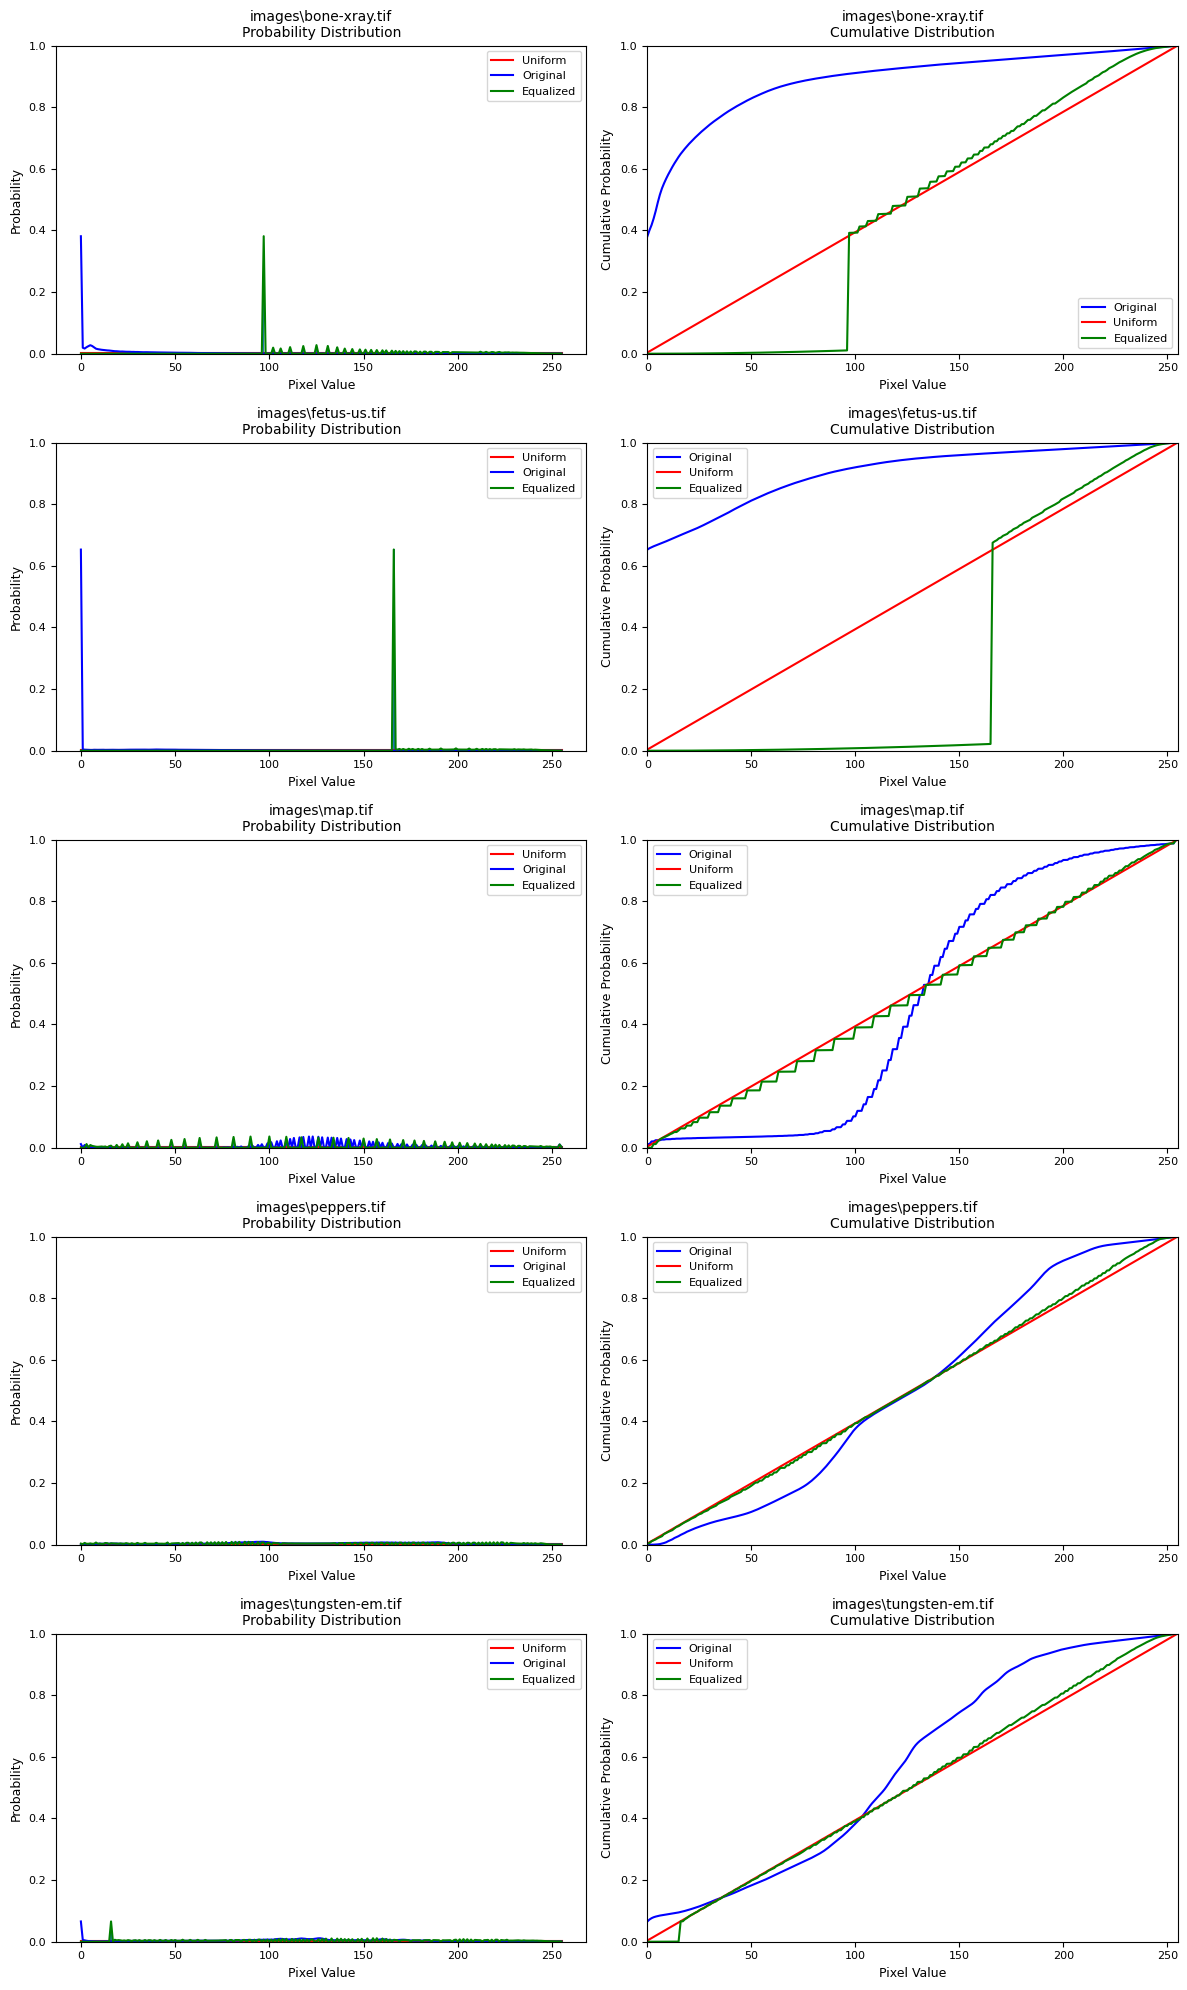

In [38]:
# Create a figure with multiple subplots based on number of images
n_images = len(image_list)
fig, axes = plt.subplots(n_images, 2, figsize=(12, 4*n_images))

# Handle case of single image
if n_images == 1:
    axes = axes.reshape(1, -1)

for idx, (img, filepath) in enumerate(zip(image_list, glob("images/*.tif"))):
    try:
        # Get image filename
        img_name = filepath.split('/')[-1]
        
        # Calculate original histogram and probabilities
        hist = histogram_calculator(img)
        prob = prob_calculator(hist)
        cumsum = cumsum_calculator(prob)
        
        # Get uniform distributions
        uniform_prob, uniform_cumsum = uniform_prob_and_cumsum()
        
        # Calculate equalized histogram
        eq_img = histogram_equalization(img)
        eq_hist = histogram_calculator(eq_img)
        eq_prob = prob_calculator(eq_hist)
        eq_cumsum = cumsum_calculator(eq_prob)
        
        # Plot equalized histogram probabilities
        axes[idx, 0].bar(range(len(eq_prob)), eq_prob)
        axes[idx, 0].plot(range(len(uniform_prob)), uniform_prob, 'r-', label='Uniform')
        axes[idx, 0].plot(range(len(prob)), prob, 'b-', label='Original')
        axes[idx, 0].plot(range(len(eq_prob)), eq_prob, 'g-', label='Equalized')
        axes[idx, 0].legend(fontsize=8)
        axes[idx, 0].set_title(f'{img_name}\nProbability Distribution', fontsize=10)
        axes[idx, 0].set_xlabel('Pixel Value', fontsize=9)
        axes[idx, 0].set_ylabel('Probability', fontsize=9)
        axes[idx, 0].tick_params(labelsize=8)
        axes[idx, 0].set_ylim(0, 1)
        
        # Plot cumulative sum
        axes[idx, 1].plot(range(len(cumsum)), cumsum, 'b-', label='Original')
        axes[idx, 1].plot(range(len(uniform_cumsum)), uniform_cumsum, 'r-', label='Uniform')
        axes[idx, 1].plot(range(len(eq_cumsum)), eq_cumsum, 'g-', label='Equalized')
        axes[idx, 1].legend(fontsize=8)
        axes[idx, 1].set_title(f'{img_name}\nCumulative Distribution', fontsize=10)
        axes[idx, 1].set_xlabel('Pixel Value', fontsize=9)
        axes[idx, 1].set_ylabel('Cumulative Probability', fontsize=9)
        axes[idx, 1].tick_params(labelsize=8)
        axes[idx, 1].set_ylim(0, 1)
        axes[idx, 1].set_xlim(0, len(cumsum)-1)
        
    except Exception as e:
        print(f"Failed to process {img_name}: {str(e)}")
        continue

plt.tight_layout()
plt.show()


In [39]:
def euclidean_distance(hist1, hist2, depth=8):
    """
    Calculate Euclidean distance between two histograms
    
    Parameters:
    hist1, hist2: array-like - input histograms of same length
    
    Returns:
    float - Euclidean distance between the histograms
    """
    if len(hist1) != len(hist2):
        raise ValueError("Histograms must have same length")
        
    return np.sqrt(np.sum((np.array(hist1) - np.array(hist2))**2)) / (2 ** depth)

def chi_square_distance(hist1, hist2, depth=8):
    """
    Calculate Chi-Square distance between two histograms
    
    Parameters: 
    hist1, hist2: array-like - input histograms of same length
    
    Returns:
    float - Chi-Square distance between the histograms
    """
    if len(hist1) != len(hist2):
        raise ValueError("Histograms must have same length")
        
    # Avoid division by zero by adding small epsilon
    eps = 1e-10
    return np.sum((np.array(hist1) - np.array(hist2))**2 / (np.array(hist1) + np.array(hist2) + eps)) / (2 ** depth)

# def bhattacharyya_distance(hist1, hist2, depth=8):
#     """
#     Calculate Bhattacharyya distance between two histograms
#     """
#     if len(hist1) != len(hist2):
#         raise ValueError("Histograms must have same length")
    
#     # Calculate Bhattacharyya distance
#     return np.sqrt(1 - np.sum(np.sqrt(np.array(hist1) * np.array(hist2)))) 

def aryan_distance_to_uniform(hist1, depth=8):
    """
    Calculate Aryan distance between a histogram and the uniform distribution
    """
    _, uniform_cdf = uniform_prob_and_cumsum()
    
    # Calculate average absolute difference between consecutive points
    diffs = (np.abs(hist1[:-1] - uniform_cdf[:-1]) + np.abs(hist1[1:] - uniform_cdf[1:])) / 2
    return np.sum(diffs) / (2 ** depth)


#TODO: ensure its hist-eq is working right and there is no float and int conversion errors or some other weird errors
#TODO: add 


In [40]:
from functools import lru_cache
import numpy as np
from PIL import Image

def image_to_hashable(img):
    """
    Convert a PIL Image to a hashable type for caching.
    
    Parameters:
    img: PIL.Image - input image
    
    Returns:
    tuple - image data as a tuple of bytes and image size
    """
    if isinstance(img, Image.Image):
        return (img.tobytes(), img.size)
    return img

@lru_cache(maxsize=None)
def histogram_equalization_n_epochs_(img_data, n):
    """
    Perform histogram equalization recursively for specified epochs on an image, caching results for each epoch.
    
    Parameters:
    img_data: tuple - input image data as a tuple of bytes and image size
    n: int - number of epochs to perform equalization
    
    Returns:
    ndarray - histogram equalized image at the specified epoch number
    """
    data, img_size = img_data
    # Base case: if n is 0, return the original image as a numpy array
    if n == 0:
        img_array = np.frombuffer(data, dtype=np.uint8).reshape((img_size[1], img_size[0]))
        return img_array
    
    # Recursive case: get the image from the previous epoch
    previous_img_array = histogram_equalization_n_epochs_((data, img_size), n - 1)
    
    # Convert previous image array to PIL Image and apply equalization
    current_img = Image.fromarray(previous_img_array)
    img_array = np.array(histogram_equalization(current_img))
    
    return img_array

def histogram_equalization_n_epochs(img, n):
    """
    Wrapper function to perform histogram equalization for a specified number of epochs on a PIL Image.
    
    Parameters:
    img: PIL.Image - input image
    n: int - number of epochs to perform equalization
    
    Returns:
    ndarray - histogram equalized image at the specified epoch number
    """
    img_data = image_to_hashable(img)
    equalized_array = histogram_equalization_n_epochs_(img_data, n)
    return equalized_array

Time taken for bone-xray with 0 epochs: 0.84864 seconds
Time taken for bone-xray with 1 epochs: 1.71178 seconds
Time taken for bone-xray with 2 epochs: 1.76948 seconds
Time taken for bone-xray with 5 epochs: 3.36472 seconds
Time taken for bone-xray with 10 epochs: 4.96625 seconds
Time taken for fetus-us with 0 epochs: 1.25343 seconds
Time taken for fetus-us with 1 epochs: 2.47584 seconds
Time taken for fetus-us with 2 epochs: 2.41223 seconds
Time taken for fetus-us with 5 epochs: 4.90718 seconds
Time taken for fetus-us with 10 epochs: 7.38622 seconds
Time taken for map with 0 epochs: 2.17665 seconds
Time taken for map with 1 epochs: 4.32976 seconds
Time taken for map with 2 epochs: 4.32274 seconds
Time taken for map with 5 epochs: 8.61568 seconds
Time taken for map with 10 epochs: 13.03439 seconds
Time taken for peppers with 0 epochs: 0.55270 seconds
Time taken for peppers with 1 epochs: 1.06483 seconds
Time taken for peppers with 2 epochs: 1.10099 seconds
Time taken for peppers with 5

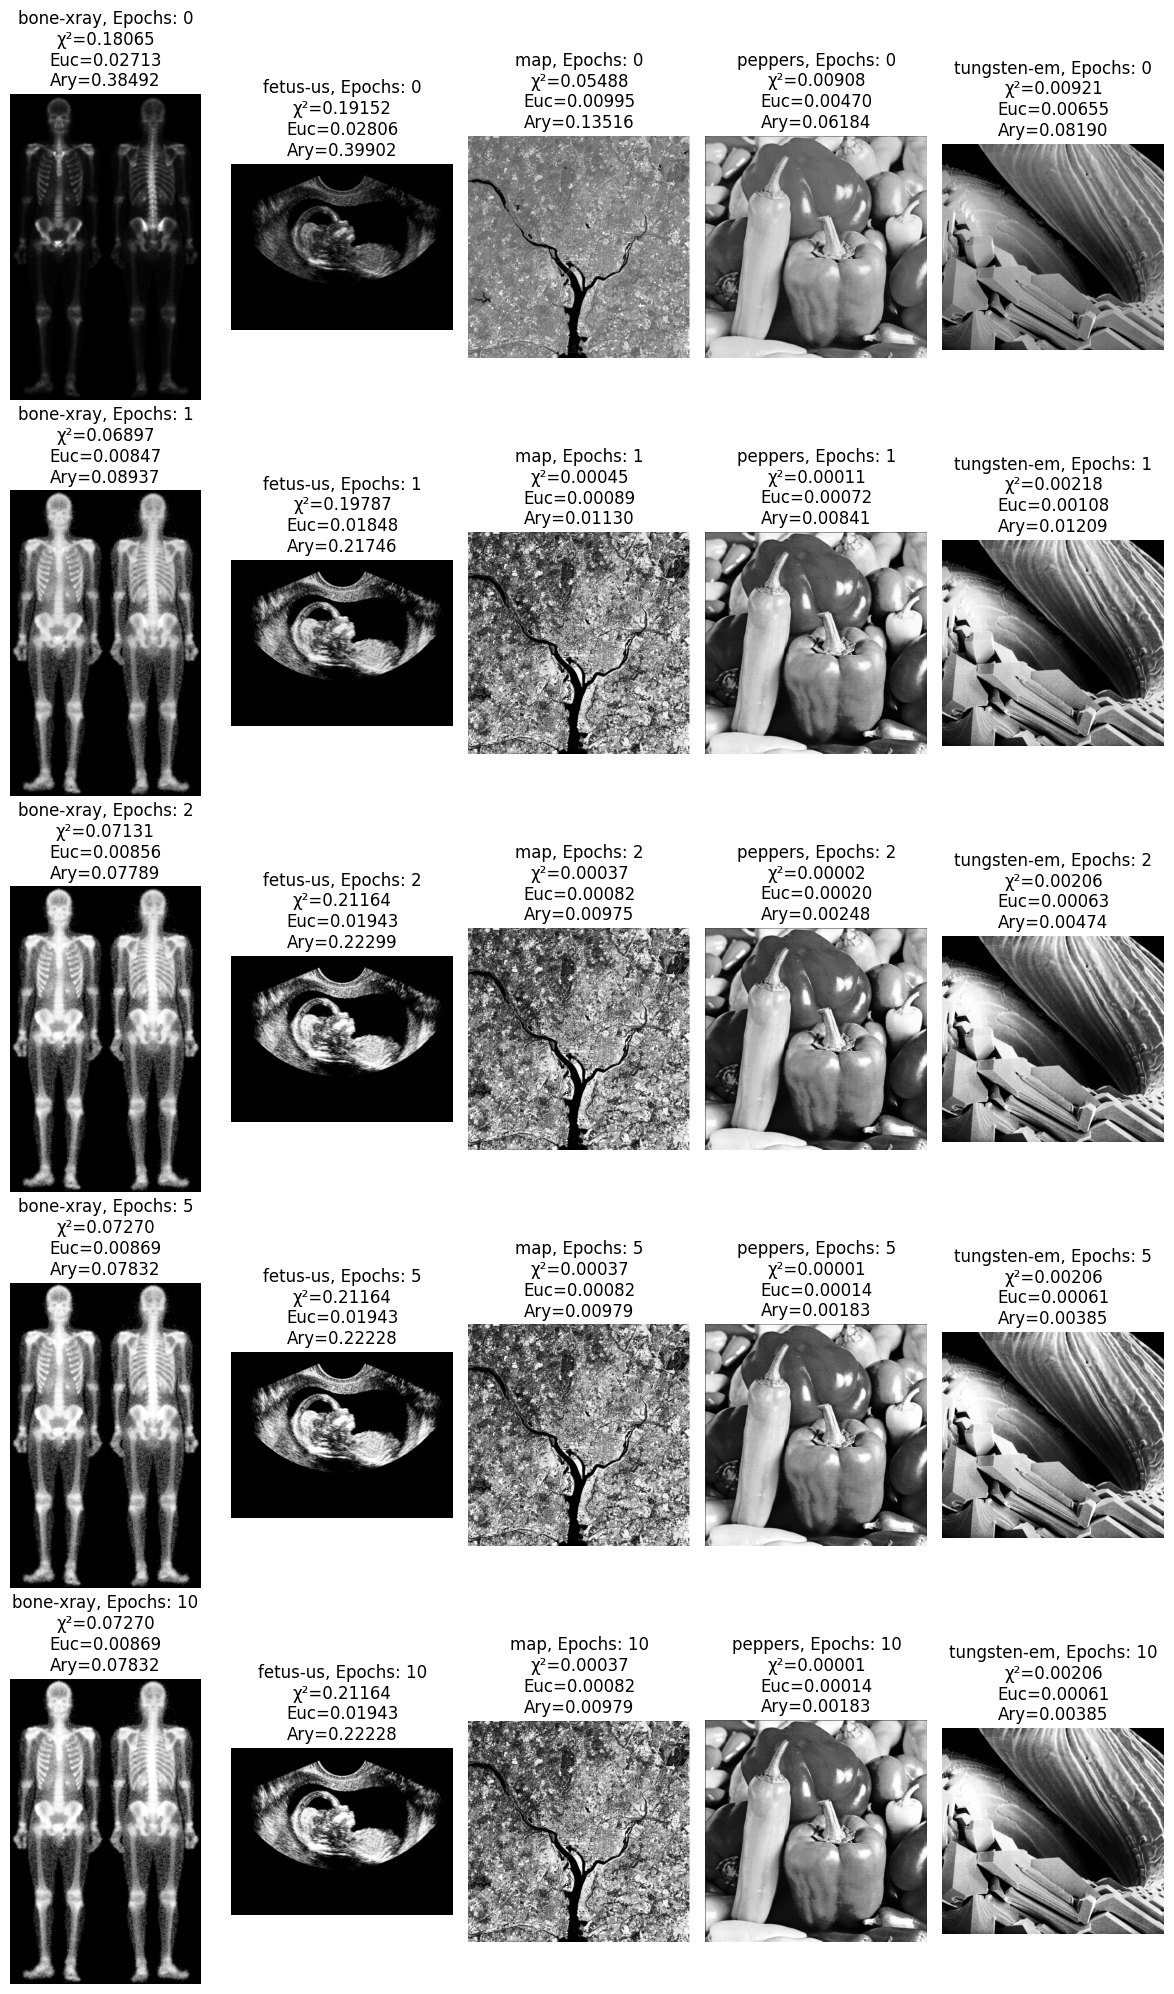

In [41]:
import time

# Create figure for visualization
plt.figure(figsize=(12, 20))

# Define number of epochs to test
epochs = [0, 1, 2, 5, 10]

# Create uniform distribution for comparison
_, uniform_cdf = uniform_prob_and_cumsum()

# Loop through all images
for i, (img, img_name) in enumerate(zip(image_list, image_names)):
    # For each number of epochs
    for j, n_epochs in enumerate(epochs):
        start_time = time.time()  # Start timing
        
        if n_epochs == 0:
            # Original image
            current_img = np.array(img.convert('L'))
        else:
            # Get the last result from the generator for the desired number of epochs
            current_img = histogram_equalization_n_epochs(img, n_epochs)
        
        # Calculate histogram and CDF
        hist = histogram_calculator(Image.fromarray(current_img))  # Use our existing histogram calculator
        prob = prob_calculator(hist)
        hist_cdf = cumsum_calculator(prob)
        
        # Calculate distances
        chi_squared = chi_square_distance(hist_cdf, uniform_cdf)
        euclidean = euclidean_distance(hist_cdf, uniform_cdf)
        aryan = aryan_distance_to_uniform(hist_cdf)
        
        # Log time taken
        end_time = time.time()
        time_taken = end_time - start_time
        print(f"Time taken for {img_name} with {n_epochs} epochs: {time_taken:.5f} seconds")
        
        # Plot image with distances
        plt.subplot(5, len(image_list), i + j*len(image_list) + 1)
        plt.imshow(current_img, cmap='gray')
        plt.title(f'{img_name}, Epochs: {n_epochs}\nχ²={chi_squared:.5f}\nEuc={euclidean:.5f}\nAry={aryan:.5f}')
        plt.axis('off')

plt.tight_layout()
plt.show()

IndexError: list index out of range

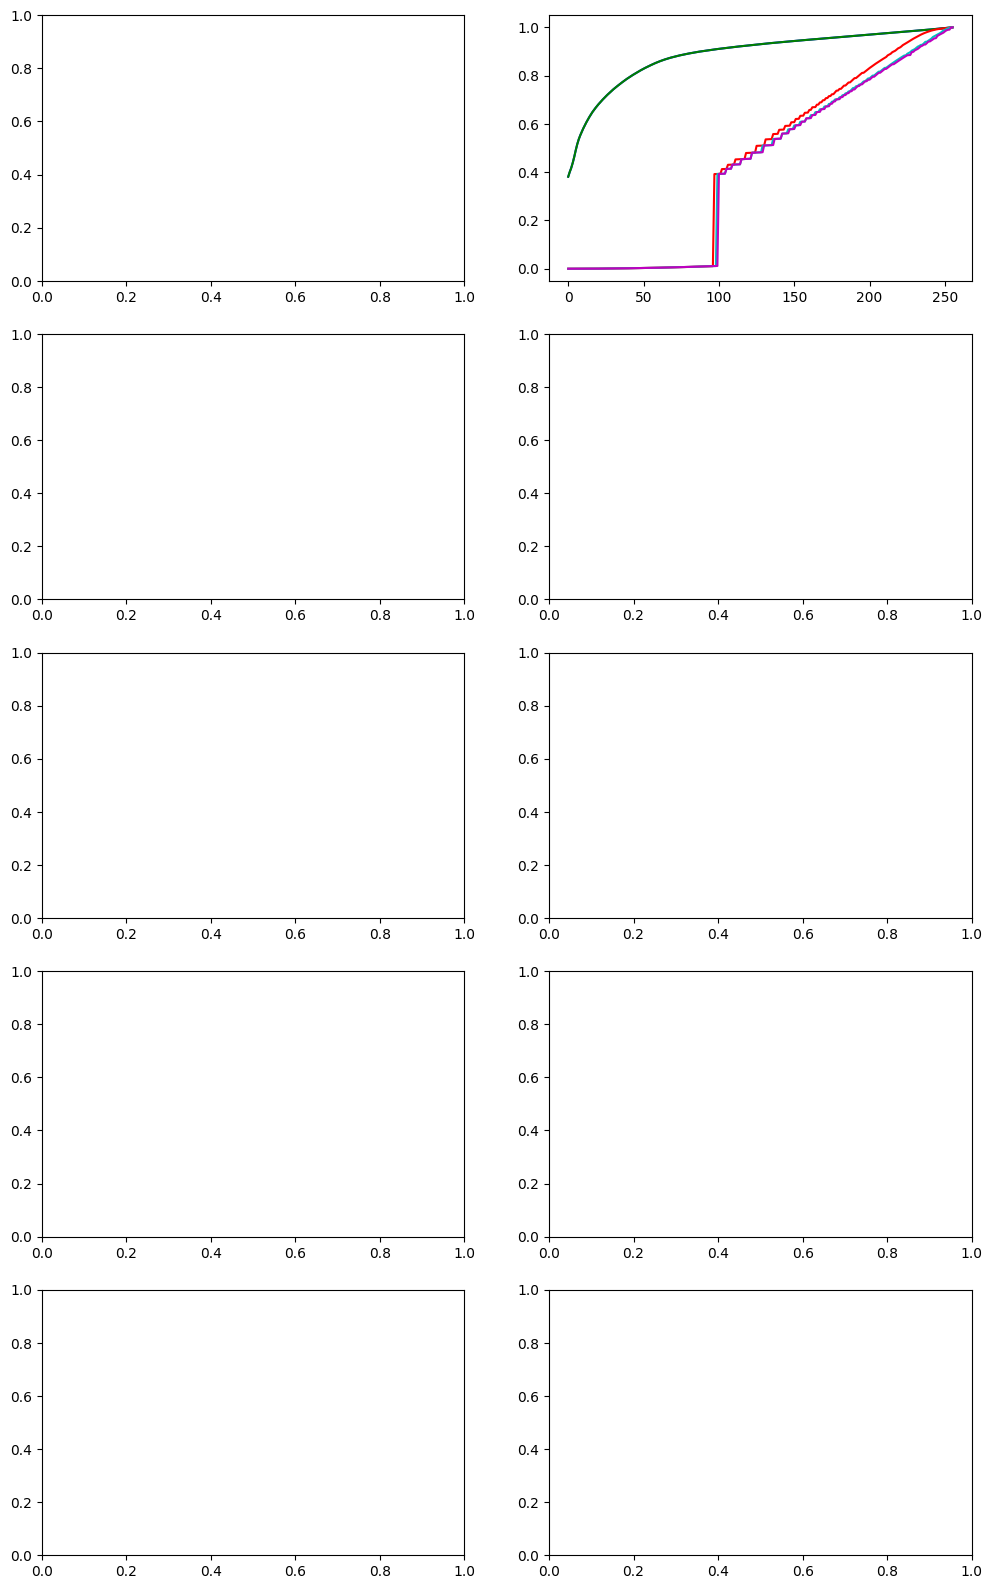

In [44]:
# Create figure for visualization
n_images = len(image_list)
fig, axes = plt.subplots(n_images, 2, figsize=(12, 4*n_images))

# Define colors for different epochs
colors = ['b', 'g', 'r', 'c', 'm', 'k']  # Original, 1, 2, 5, 10, Uniform
epochs = [0, 1, 2, 5, 10]

# Create uniform distribution
uniform_prob, uniform_cdf = uniform_prob_and_cumsum()

# Loop through images
for img_idx, (img, img_name) in enumerate(zip(image_list, image_names)):
    # Store histograms and CDFs for all epochs
    all_probs = []
    all_cdfs = []
    
    # Get original image first
    current_img = np.array(img.convert('L'))
    hist = histogram_calculator(Image.fromarray(current_img))
    prob = prob_calculator(hist)
    cumsum = cumsum_calculator(prob)
    all_probs.append(prob)
    all_cdfs.append(cumsum)
    
    # Get all epoch results at once
    epoch_results = [histogram_equalization_n_epochs(img, i) for i in epochs[1:]] # Skip 0 as we already have it
    
    # Calculate histograms for each epoch result
    for img_array in epoch_results:
        hist = histogram_calculator(Image.fromarray(img_array))
        prob = prob_calculator(hist)
        cumsum = cumsum_calculator(prob)
        all_probs.append(prob)
        all_cdfs.append(cumsum)
    
    # Plot CDFs (right column)
    for idx, cdf in enumerate(all_cdfs):
        axes[img_idx, 1].plot(range(len(cdf)), cdf, color=colors[idx], 
                            label=f'Epochs: {epochs[idx]}')
    axes[img_idx, 1].plot(range(len(uniform_cdf)), uniform_cdf, color=colors[-1], 
                         label='Uniform', linestyle='--')
    axes[img_idx, 1].set_title(f'{img_name}\nCumulative Distribution')
    axes[img_idx, 1].set_xlabel('Pixel Value')
    axes[img_idx, 1].set_ylabel('Cumulative Probability')
    axes[img_idx, 1].legend(fontsize=8)
    axes[img_idx, 1].set_ylim(0, 1)
    axes[img_idx, 1].set_xlim(0, len(uniform_cdf)-1)
    
    # Plot probability distributions (left column)
    for idx, prob in enumerate(all_probs):
        axes[img_idx, 0].plot(range(len(prob)), prob, color=colors[idx], 
                            label=f'Epochs: {epochs[idx]}')
    
    # Plot uniform distribution
    axes[img_idx, 0].plot(range(len(uniform_prob)), uniform_prob, color=colors[-1], 
                         label='Uniform', linestyle='--', linewidth=2)
    
    axes[img_idx, 0].set_title(f'{img_name}\nProbability Distribution')
    axes[img_idx, 0].set_xlabel('Pixel Value')
    axes[img_idx, 0].set_ylabel('Probability')
    axes[img_idx, 0].legend(fontsize=8)
    axes[img_idx, 0].set_ylim(0, max(max(prob) for prob in all_probs) * 1.1)
    axes[img_idx, 0].set_xlim(0, len(uniform_prob)-1)

plt.tight_layout()
plt.show()


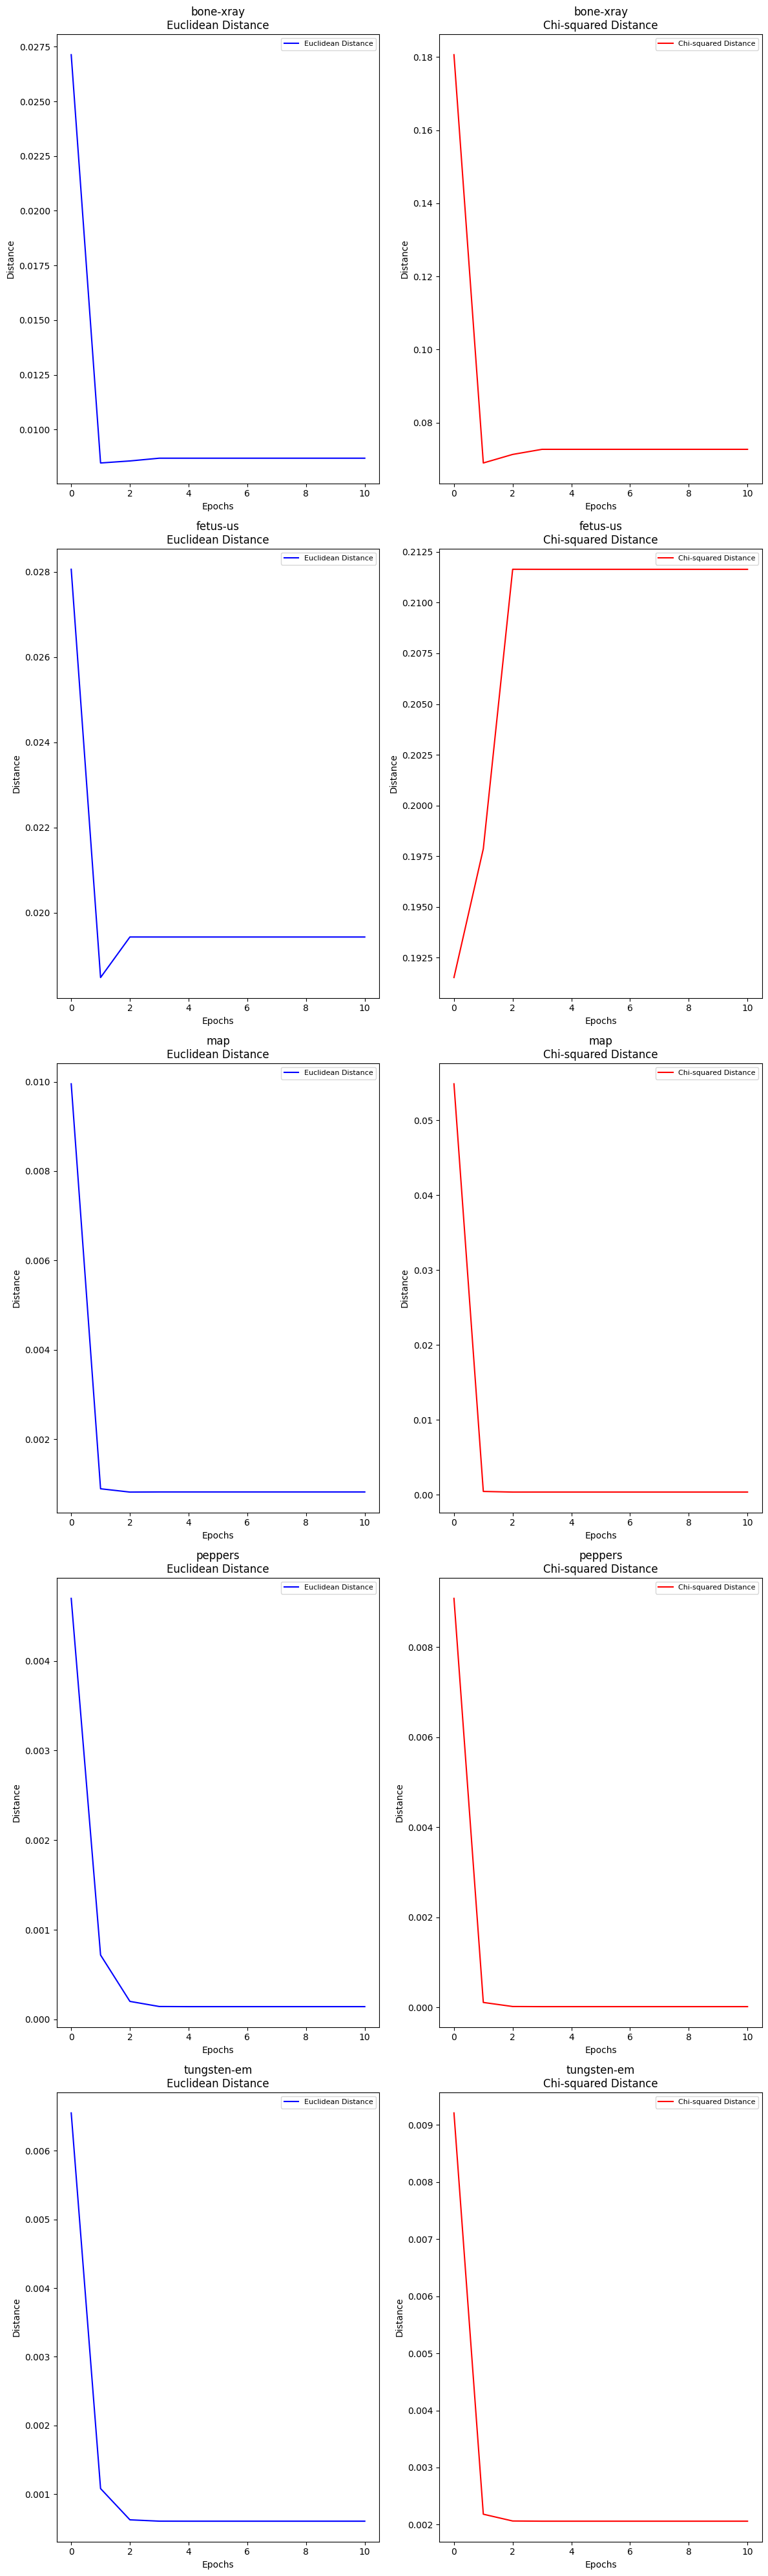

In [29]:
# Draw the chart of distance from 

# Create uniform distribution
uniform_prob, uniform_cdf = uniform_prob_and_cumsum()

EPOCH_COUNT = 10
EPOCH_COUNTS = [i for i in range(EPOCH_COUNT+1)]

# Prepare figure and axes for plotting
fig, axes = plt.subplots(len(image_list), 2, figsize=(12, 8 * len(image_list)))

# Loop through images
for img_idx, (img, img_name) in enumerate(zip(image_list, image_names)):
    # Apply histogram, then prob, then cdf
    original_hist = histogram_calculator(Image.fromarray(np.array(img.convert('L'))))
    original_prob = prob_calculator(original_hist)
    original_cdf = cumsum_calculator(original_prob)
    
    # Calculate distances for each epoch result
    euclidean_distances = []
    chi_squared_distances = []
    
    for i in range(EPOCH_COUNT+1):
        hist = histogram_calculator(Image.fromarray(histogram_equalization_n_epochs(img, i)))
        prob = prob_calculator(hist)
        cdf = cumsum_calculator(prob)
        
        # Euclidean distance
        ed = euclidean_distance(uniform_cdf, cdf)
        euclidean_distances.append(ed)
        
        # Chi-squared distance
        chi2 = chi_square_distance(uniform_cdf, cdf)
        chi_squared_distances.append(chi2)
    
    # Plot Euclidean distances
    axes[img_idx, 0].plot(EPOCH_COUNTS, euclidean_distances, color='b', label='Euclidean Distance')
    axes[img_idx, 0].set_title(f'{img_name}\nEuclidean Distance')
    axes[img_idx, 0].set_xlabel('Epochs')
    axes[img_idx, 0].set_ylabel('Distance')
    axes[img_idx, 0].legend(fontsize=8)
    
    # Plot Chi-squared distances
    axes[img_idx, 1].plot(EPOCH_COUNTS, chi_squared_distances, color='r', label='Chi-squared Distance')
    axes[img_idx, 1].set_title(f'{img_name}\nChi-squared Distance')
    axes[img_idx, 1].set_xlabel('Epochs')
    axes[img_idx, 1].set_ylabel('Distance')
    axes[img_idx, 1].legend(fontsize=8)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()